In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

## Creation of the matrix (just load, last line)

In [17]:
# Load the user matrix
f=open("user_matrix","rb")
user_matrix = pickle.load(f)
f.close()

In [2]:
user_matrix = pd.read_pickle('matrix.p') #Load directly the matrix
user_matrix = user_matrix[1:] #first row is empty

In [3]:
user_matrix = np.array(user_matrix)

## Clusters on healthiness scale

**Select some aisles**

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
pd.set_option('display.max_rows', None) #show all the rows
print(aisles)
pd.set_option('display.max_rows', 20)

     aisle_id                          aisle
0           1          prepared soups salads
1           2              specialty cheeses
2           3            energy granola bars
3           4                  instant foods
4           5     marinades meat preparation
5           6                          other
6           7                  packaged meat
7           8                bakery desserts
8           9                    pasta sauce
9          10               kitchen supplies
10         11               cold flu allergy
11         12                    fresh pasta
12         13                 prepared meals
13         14         tofu meat alternatives
14         15               packaged seafood
15         16                    fresh herbs
16         17             baking ingredients
17         18   bulk dried fruits vegetables
18         19                  oils vinegars
19         20                   oral hygiene
20         21                packaged cheese
21        

We will select only 14 aisles, directly link to the healthiness of the order. 7 of them characterize healthy user, while 7 others characterize unhealthy users.

In [5]:
aisles_health = aisles.loc[[3,12,15,16,23,37,44,49,60,68,76,78,82,122]] #select aisles discriminating on aisles
pd.set_option('display.max_rows', None)
print(aisles_health)
pd.set_option('display.max_rows', 20)

     aisle_id                       aisle
3           4               instant foods
12         13              prepared meals
15         16                 fresh herbs
16         17          baking ingredients
23         24                fresh fruits
37         38                frozen meals
44         45             candy chocolate
49         50      fruit vegetable snacks
60         61               cookies cakes
68         69         soup broth bouillon
76         77                 soft drinks
78         79                frozen pizza
82         83            fresh vegetables
122       123  packaged vegetables fruits


In [6]:
np.shape(user_matrix) 

(206209, 135)

**Create matrix**

In [6]:
matrix_health = user_matrix[:,aisles_health.aisle_id]

In [7]:
row_sums = matrix_health.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = matrix_health / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


**Dimensionnality reduction**

In [9]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
reduc_matrix = pca.transform(norm_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

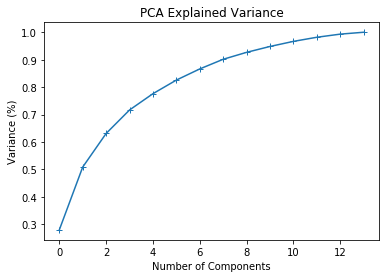

In [11]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=4

In [11]:
pca = PCA(n_components=4, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [13]:
reduc_matrix.shape

(206209, 4)

Understand the new dimension vectors by looking at the features impacting them the most

In [9]:
aisle_list = list(aisles_health.aisle)
i=0
for d in pca.components_ :
    print("dimension" + str(i)+" ") 
    i+=1
    if(abs(np.max(d))>abs(np.min(d))):
        print(str(aisle_list[np.argmax(d)]) + " " + str(np.max(d)))
    else :
        print(str(aisle_list[np.argmin(d)])+" "+str(np.min(d)))

dimension0 
fresh fruits 0.8573869523803067
dimension1 
fresh vegetables -0.7682719352777929
dimension2 
packaged vegetables fruits 0.862313710156931
dimension3 
soft drinks 0.7219967107264166


The aisles defining the independant dimensions arr fruits, vegetables and soft drinks. The three first influencing features are all healthy, only the 4th is unhealthy. The risk is that the cluster won't differentiate between healthy and unhealthy but between other criteria (eat more salty or sweet for isntance).

**CLustering**

Determine the right number of clusters (k)

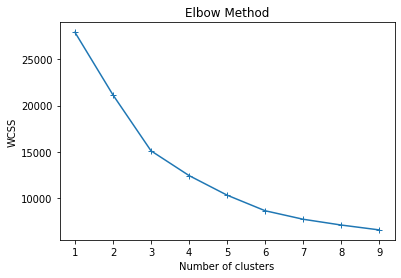

In [15]:
#un peu long
wcss=[]
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 3 with this method

In [12]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(reduc_matrix)

**Analyse of the clusters**

In [17]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [18]:
get_cluster_size(kmeans, 3, reduc_matrix)

54121.0
58289.0
93798.0


The 3 clusters obtained are about the same size.

**Look at centroids distance**

In [19]:
kmeans.cluster_centers_

array([[-0.07994422,  0.27849399, -0.00209435, -0.02952437],
       [ 0.28303917, -0.0322645 ,  0.01024551,  0.00849   ],
       [-0.12961092, -0.14095822, -0.00515388,  0.01179436]])

In [20]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [21]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        ],
       [0.47950511, 0.        , 0.        ],
       [0.42440963, 0.42701578, 0.        ]])

The three centroids are well separated from each others.

**prepare df**

In [13]:
#convert the matrix into df
matrix_df = pd.DataFrame(matrix_health, index = range(len(matrix_health)), columns = list(aisles_health.aisle) )
matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
0,0,0,0,0,5,0,1,0,0,0,13,0,0,0
1,0,0,0,2,33,12,0,0,0,0,0,0,0,3
2,4,2,0,0,19,0,0,0,0,0,0,0,5,14
3,0,0,0,0,2,3,0,0,0,1,1,0,0,0
4,0,0,1,0,4,0,0,0,0,0,0,0,6,8


In [14]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits,cluster
0,0,0,0,0,5,0,1,0,0,0,13,0,0,0,0
1,0,0,0,2,33,12,0,0,0,0,0,0,0,3,1
2,4,2,0,0,19,0,0,0,0,0,0,0,5,14,1
3,0,0,0,0,2,3,0,0,0,1,1,0,0,0,0
4,0,0,1,0,4,0,0,0,0,0,0,0,6,8,2


In [15]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = list(aisles_health.aisle) )
norm_matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
0,0.000000,0.000000,0.000000,0.00,0.263158,0.000000,0.052632,0.0,0.0,0.000000,0.684211,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.04,0.660000,0.240000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.060000
2,0.090909,0.045455,0.000000,0.00,0.431818,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.113636,0.318182
3,0.000000,0.000000,0.000000,0.00,0.285714,0.428571,0.000000,0.0,0.0,0.142857,0.142857,0.0,0.000000,0.000000
4,0.000000,0.000000,0.052632,0.00,0.210526,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.315789,0.421053


In [16]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits,cluster
0,0.000000,0.000000,0.000000,0.00,0.263158,0.000000,0.052632,0.0,0.0,0.000000,0.684211,0.0,0.000000,0.000000,0
1,0.000000,0.000000,0.000000,0.04,0.660000,0.240000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.060000,1
2,0.090909,0.045455,0.000000,0.00,0.431818,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.113636,0.318182,1
3,0.000000,0.000000,0.000000,0.00,0.285714,0.428571,0.000000,0.0,0.0,0.142857,0.142857,0.0,0.000000,0.000000,0
4,0.000000,0.000000,0.052632,0.00,0.210526,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.315789,0.421053,2


**Study the mean distribution of products per ailse in each clusters**

In [26]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,instant foods,prepared meals,fresh herbs,baking ingredients,fresh fruits,frozen meals,candy chocolate,fruit vegetable snacks,cookies cakes,soup broth bouillon,soft drinks,frozen pizza,fresh vegetables,packaged vegetables fruits
cluster,,,,,,,,,,,,,,
0,0.038621,0.014837,0.011336,0.061036,0.099702,0.094787,0.076497,0.030404,0.063330,0.050468,0.153495,0.034869,0.060554,0.123481
1,0.014288,0.007615,0.012898,0.022638,0.540408,0.020424,0.021125,0.015967,0.019044,0.019772,0.023017,0.011074,0.121723,0.150005
2,0.014650,0.006574,0.040861,0.029822,0.233271,0.018304,0.014037,0.008855,0.011307,0.032495,0.014885,0.010722,0.416134,0.148084


**Evaluate the features discrimining the clusters**

In [27]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

soft drinks                  -0.203098
frozen meals                 -0.127213
cookies cakes                -0.103952
candy chocolate              -0.080406
frozen pizza                 -0.051405
instant foods                -0.031246
fruit vegetable snacks       -0.018286
prepared meals               -0.005475
soup broth bouillon           0.080042
baking ingredients            0.087544
fresh fruits                  0.176745
packaged vegetables fruits    0.198623
fresh herbs                   0.250135
fresh vegetables              0.383619
cluster                       1.000000
Name: cluster, dtype: float64

As we will show later, the higher the number of the cluster, the healthier it is. Thus a positive correlation between an aisle and the clusters means it is considerated as an healthy criteria. All our 7 healthy aisles have positive correlation, exept fruits snacks. All our 7 unhealthy aisles have negative correlation. This our labellization of the clusters, and the t that they can be distinguish in an healthiness scale. 

In [28]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [29]:
scores = SelectKBest(chi2, k='all').fit(X, Y)

In [30]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(14)

,Score
fresh vegetables,22822.964809
fresh fruits,20740.411468
soft drinks,13725.628252
frozen meals,5868.191920
candy chocolate,4448.448471
cookies cakes,3617.926500
fresh herbs,1675.277969
frozen pizza,1341.517587
baking ingredients,1331.518997
instant foods,1113.694097


Important aisles discriming the clusters. As expected, consumption of fresh fruits and vegetables are really meaningfull. Then the comsumption of oft drinks and frozen meals charcaterize the unhealthy users.

In [31]:
mean_clusters[features.index]

,fresh vegetables,fresh fruits,soft drinks,frozen meals,candy chocolate,cookies cakes,fresh herbs,frozen pizza,baking ingredients,instant foods,fruit vegetable snacks,soup broth bouillon,prepared meals,packaged vegetables fruits
cluster,,,,,,,,,,,,,,
0,0.060554,0.099702,0.153495,0.094787,0.076497,0.063330,0.011336,0.034869,0.061036,0.038621,0.030404,0.050468,0.014837,0.123481
1,0.121723,0.540408,0.023017,0.020424,0.021125,0.019044,0.012898,0.011074,0.022638,0.014288,0.015967,0.019772,0.007615,0.150005
2,0.416134,0.233271,0.014885,0.018304,0.014037,0.011307,0.040861,0.010722,0.029822,0.014650,0.008855,0.032495,0.006574,0.148084


0 : + soft drinks ; + frozen meals ; + candy ; + cakes ; +pizza ; + baking !!!! ; +instant ; + fruits snacks !!!! ; + soup !!!!! ; + prepared 

1 : + fruits ; 

2 : + vegetables ; +herbs ; 

classification healthiness : 2 > 1 > 0

## Vizualisation 

aisles as scales 

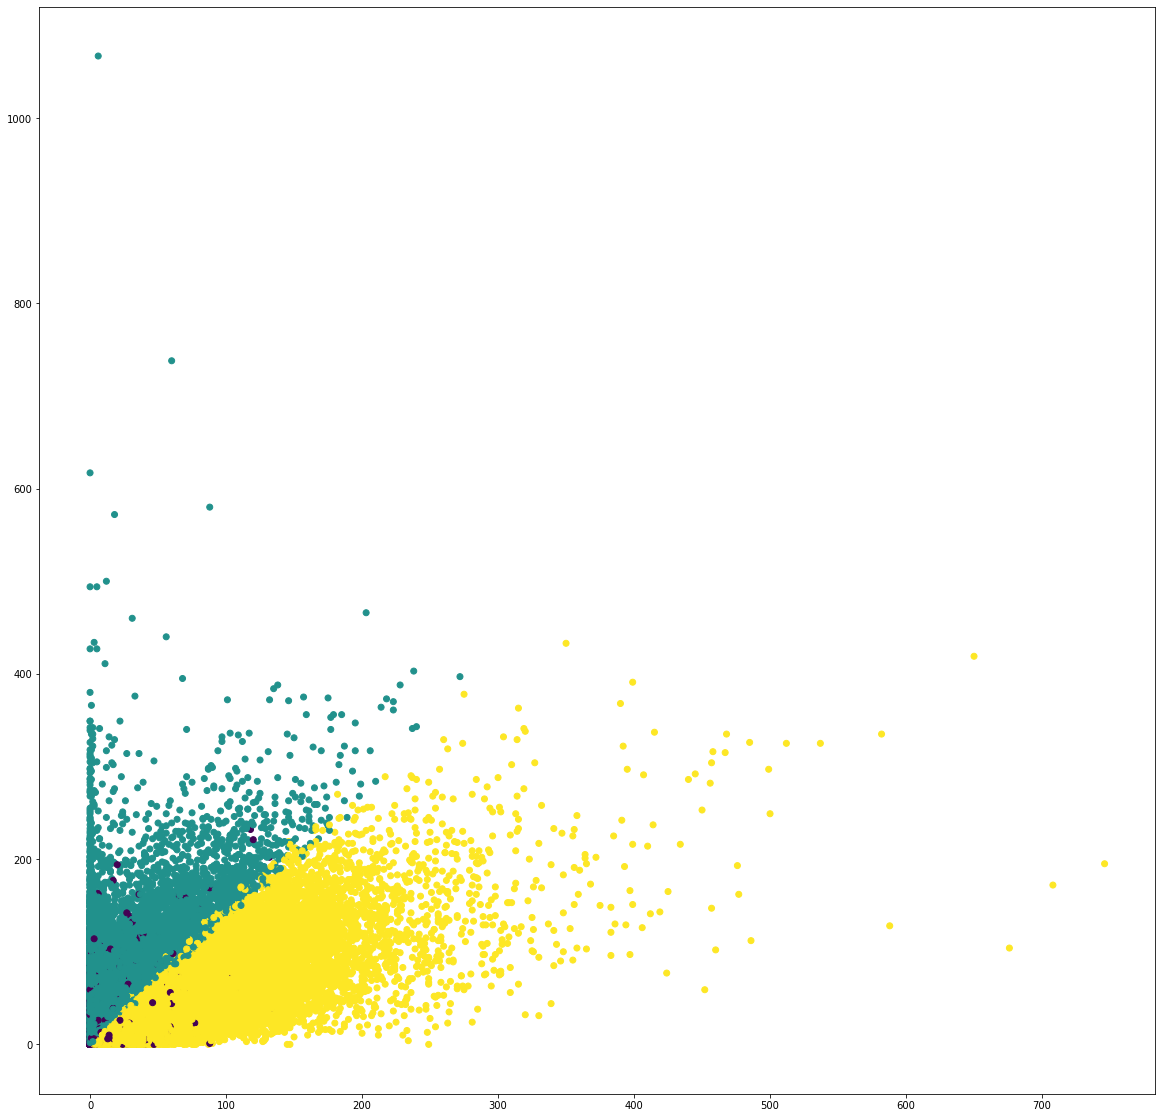

In [32]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['fresh fruits'], c=matrix_df['cluster'], cmap='viridis')

We can see that in this dimensions (aisles with high weigh on 2 first PCA dimensions), 2 clusters are well defined (the 1 and 2). But the separation seems artifically imposed. Actually this means the two healthy users group is separating people eating more vegetables or fruits.

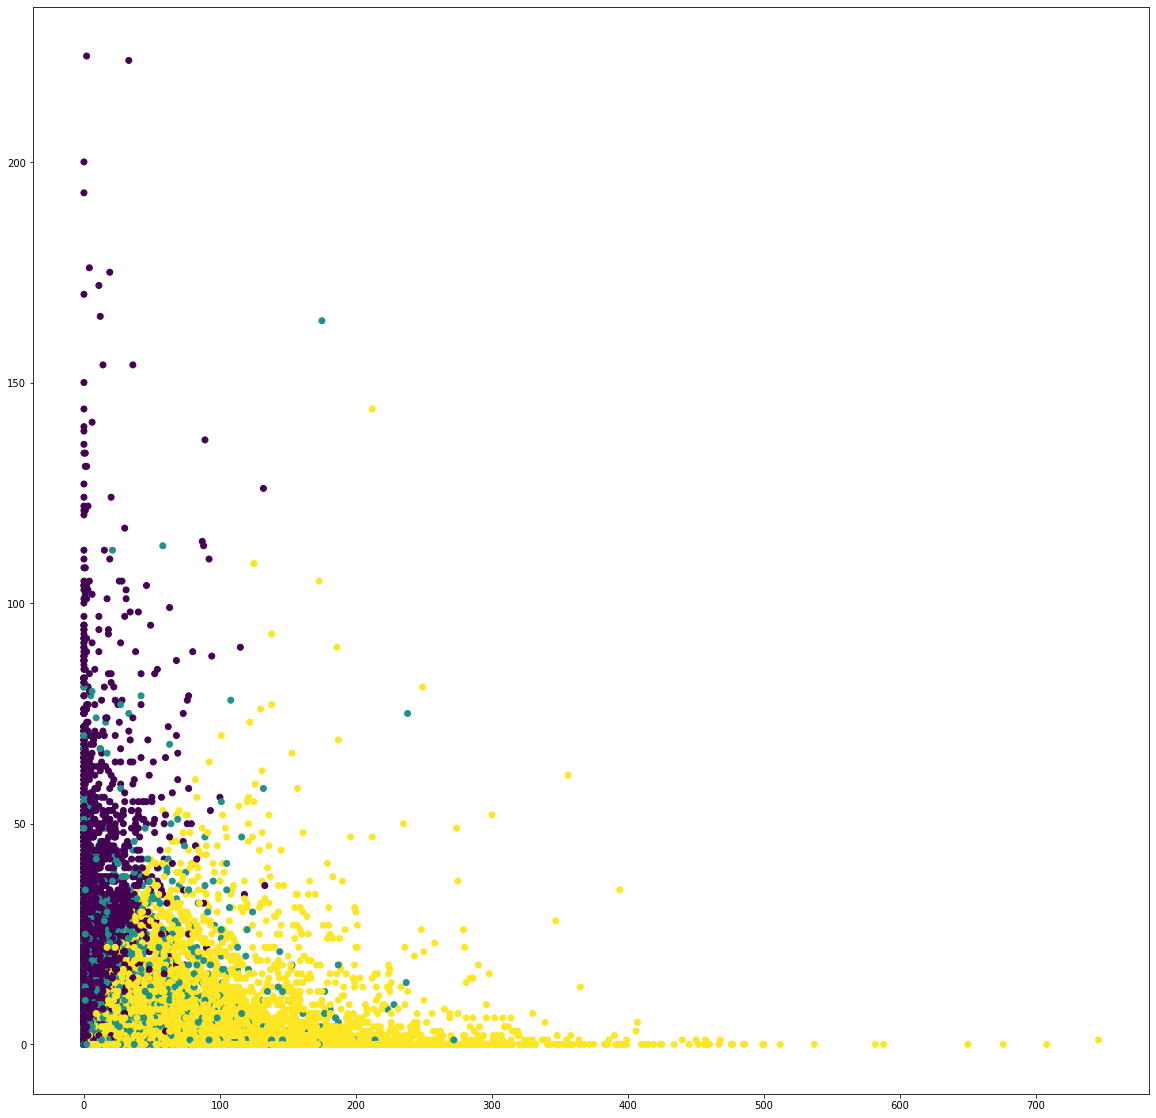

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['soft drinks'], c=matrix_df['cluster'], cmap='viridis')

When including an unhealthy aisle in the scale : Clusters are not well separated.

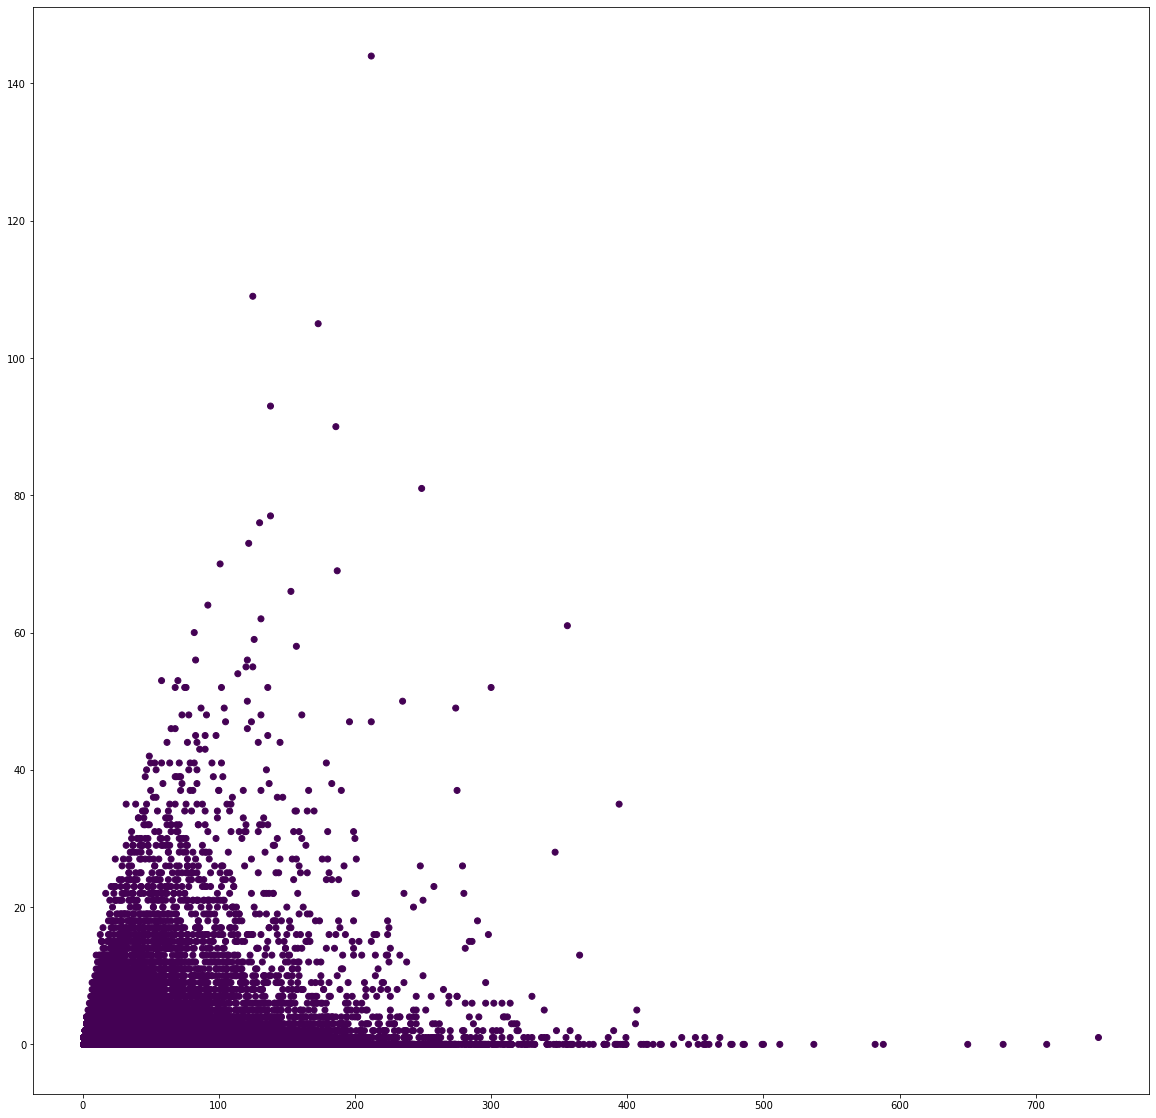

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
dessin = matrix_df[matrix_df.cluster ==2 ]
ax.scatter(dessin['fresh vegetables'], dessin['soft drinks'], c=dessin['cluster'], cmap='viridis')

We can just see that healthy users (cluster 2) do not drink lots of soft drinks, almost at all

PCA dim as scales

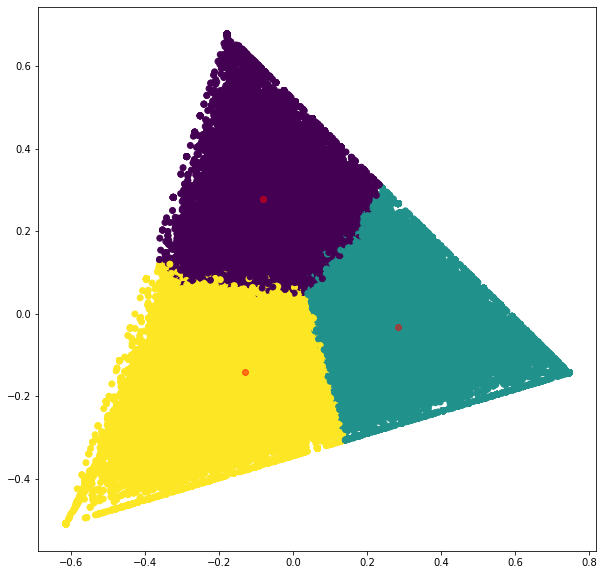

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduc_matrix[:,0], reduc_matrix[:,1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], c='red', alpha=0.5);

Representation in the first two dimensions of the PCA. We can see how the clusters were defined. The three clusters are much well defined, but like before, the separation seems artificially imposed. This is probably due to a difficulty to really differentiate the users, because of the continuum if their habits.

## Habits

In [12]:
orders = pd.read_csv('data/orders.csv', sep=',')

In [38]:
def stats_cluster(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]

    # Timing of orders
    print (orders[orders.user_id.isin(user)].groupby('order_id').mean().describe())

In [39]:
stats_cluster(0)

             user_id   order_number      order_dow  order_hour_of_day  \
count  895494.000000  895494.000000  895494.000000      895494.000000   
mean   102882.132453      17.022546       2.772951          13.469488   
std     59493.084997      17.569537       2.046888           4.232728   
min         3.000000       1.000000       0.000000           0.000000   
25%     51884.000000       5.000000       1.000000          10.000000   
50%    102604.000000      11.000000       3.000000          13.000000   
75%    153893.000000      23.000000       5.000000          16.000000   
max    206205.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           841373.000000  
mean                11.133742  
std                  9.210840  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [40]:
stats_cluster(1)

             user_id   order_number      order_dow  order_hour_of_day  \
count  969506.000000  969506.000000  969506.000000      969506.000000   
mean   103319.076853      17.247200       2.776585          13.449769   
std     59451.200535      17.815528       2.047270           4.226431   
min         1.000000       1.000000       0.000000           0.000000   
25%     51574.000000       5.000000       1.000000          10.000000   
50%    103186.000000      11.000000       3.000000          13.000000   
75%    154658.000000      24.000000       5.000000          16.000000   
max    206208.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           911217.000000  
mean                11.097471  
std                  9.197051  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [41]:
stats_cluster(2)

            user_id  order_number     order_dow  order_hour_of_day  \
count  1.556069e+06  1.556069e+06  1.556069e+06       1.556069e+06   
mean   1.028202e+05  1.717355e+01  2.777870e+00       1.344336e+01   
std    5.960706e+04  1.777503e+01  2.046522e+00       4.222033e+00   
min    4.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%    5.100900e+04  5.000000e+00  1.000000e+00       1.000000e+01   
50%    1.024700e+05  1.100000e+01  3.000000e+00       1.300000e+01   
75%    1.545210e+05  2.300000e+01  5.000000e+00       1.600000e+01   
max    2.062070e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order  
count            1.462271e+06  
mean             1.111471e+01  
std              9.210351e+00  
min              0.000000e+00  
25%              4.000000e+00  
50%              7.000000e+00  
75%              1.500000e+01  
max              3.000000e+01  


There is no differences of users's habits between the clusters... (days and hour of orders, days after the last order, number of orders). This is disappointing, there is no advice to give to the less healthy group here.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [14]:
def orders_qte(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]
    order_cluster = orders[orders.user_id.isin(user)].order_id
    print(history[history.order_id.isin(order_cluster)].groupby('order_id').count().mean())

In [ ]:
orders_qte(0)

In [ ]:
orders_qte(1)

In [ ]:
orders_qte(2)

_Je n'ai pas réussi à run pour voir le nb de produits pas order, mais j'y crois assez peu_

## Client fidelity and ranking of products

Pierre part :

In [3]:
import pickle
f=open("history_small","rb")
history_small = pickle.load(f)
f.close()

In [4]:
consumptions = pd.merge(history_small, orders, on="order_id")
consumptions["product_id_bis"]=consumptions["product_id"]

In [5]:
consumptions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id_bis
0,2,33120,1,1,202279,prior,3,5,9,8.0,33120
1,2,28985,2,1,202279,prior,3,5,9,8.0,28985
2,2,9327,3,0,202279,prior,3,5,9,8.0,9327
3,2,45918,4,1,202279,prior,3,5,9,8.0,45918
4,2,30035,5,0,202279,prior,3,5,9,8.0,30035


#### Fidelity = number of times each user re-bought each product

In [6]:
fidelity = consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum","product_id_bis" :"mean"})

#### Fidelity_per_user = number of times each user re-bought a product, on average

In [7]:
fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'}).rename(columns={"reordered": "user_fidelity"})
fidelity_per_user_notnull = fidelity_per_user[fidelity_per_user.user_fidelity>0]
fidelity_per_user_notnull.sort_values("user_fidelity").head()

,user_fidelity
user_id,
170452,0.012658
55086,0.020000
129873,0.020000
56718,0.020000
126770,0.021277


#### Satisfaction_per_product = number of times each product is re-bought by users, on average

In [8]:
satisfaction_per_product = fidelity.groupby("product_id").agg({'reordered':'mean'}).rename(columns={"reordered": "satisfaction_per_product"})

In [9]:
satisfaction_per_product.sort_values("satisfaction_per_product").tail()

,satisfaction_per_product
product_id,
25593,5.500000
21482,6.000000
12995,6.666667
12981,7.000000
19675,8.000000


#### Product_quality = how users like the product (weighted average over user fidelity)

In [10]:
with_user_fidelity = pd.merge(fidelity, fidelity_per_user_notnull, on="user_id")
with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity

In [11]:
quality_per_product = with_user_fidelity.groupby("product_id_bis").agg({"appreciation_per_user":"mean"})

In [12]:
quality_per_product.sort_values("appreciation_per_user").tail()

,appreciation_per_user
product_id_bis,
39746,10.840064
25135,11.333333
32612,15.250000
16424,19.000000
36433,19.302239


In [13]:
quality_per_product["count"]=1
quality_per_product["appreciation_per_user"]=round(quality_per_product["appreciation_per_user"],2)
distribution_qualities = quality_per_product.groupby("appreciation_per_user").agg({"count":"sum"})

Text(0.5, 1.0, 'User appreciation distribution')

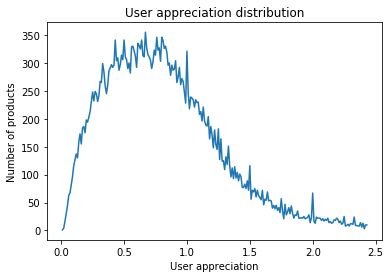

In [14]:
Y = list(distribution_qualities.values)
X = list(distribution_qualities.index)
l = round(len(Y)/2)
plt.plot(X[1:l],Y[1:l])
plt.xlabel("User appreciation")
plt.ylabel("Number of products")
plt.title("User appreciation distribution")

Left-skewed distribution, with average 1 by definition (we normalized by user enthousiasm).

#### Now let's try to get a "satisfaction score" for each aisle

We might think about averaging the scores, but some of them may be undefined, and some products might be much more consumed than others.

In [15]:
# Weight given to each product = number of times it was bought
consumptions["count_consumptions"] = 1
product_weights = consumptions.groupby("product_id").agg({"count_consumptions":"sum"})

In [16]:
# Columns of qualities_and_weights : product_id || score of the product || number of times it was bought
quality_per_product["product_id"] = quality_per_product.index
qualities_and_weights = pd.merge(product_weights, quality_per_product, on="product_id")

# qualities_joined links the previous dataset with data about products (aisle, department...)
qualities_joined = pd.merge(qualities_and_weights, products, on="product_id")
qualities_joined["sum_appreciations"]=qualities_joined.appreciation_per_user * qualities_joined.count_consumptions

In [17]:
qualities_joined.head()

,product_id,count_consumptions,appreciation_per_user,count,product_name,aisle_id,department_id,sum_appreciations
0,1,290,0.72,1,Chocolate Sandwich Cookies,61,19,208.80
1,2,14,0.10,1,All-Seasons Salt,104,13,1.40
2,3,27,1.54,1,Robust Golden Unsweetened Oolong Tea,94,7,41.58
3,4,46,0.74,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,34.04
4,5,2,1.06,1,Green Chile Anytime Sauce,5,13,2.12


In [20]:
# Quality of an aisle = weighted average of scores of its products

# Group by aisle remembering sum of scores and total weight
aisle_avg_quality = qualities_joined.groupby("aisle_id").agg({"count_consumptions":"sum","sum_appreciations":"sum"})

# Make a smart division to obtain weighted average
aisle_avg_quality["aisle_score"] = aisle_avg_quality.sum_appreciations / aisle_avg_quality.count_consumptions

# Put the name of the aisle with previous data
aisle_avg_quality = pd.merge(aisle_avg_quality[["aisle_score","count_consumptions"]], aisles, on="aisle_id")

The score is difficult to interpret. Nevertheless, a score bigger than 1 means that the majority of products bought in the aisle are more often re-consumed than the overall average. The smaller the score, the less often consumers tend to re-buy the products of the aisle.

The column "count_consumptions" may be considered as the reilabilit of the score. The smaller, the less orders were made from this aisle, the more an outlier consumer can biase the score.

In [45]:
# Aisles that contain most "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").tail(50)

,aisle_id,aisle_score,count_consumptions,aisle
127,128,0.919202,29900,tortillas flat bread
53,54,0.919672,37377,paper goods
49,50,0.920789,27271,fruit vegetable snacks
6,7,0.930176,5069,packaged meat
124,125,0.930303,5542,trail mix snack mix
56,57,0.934326,16123,granola
47,48,0.950905,11291,breakfast bars pastries
41,42,0.955150,15560,frozen vegan vegetarian
105,106,0.956703,46845,hot dogs bacon sausage
70,71,0.959261,5818,refrigerated pudding desserts


In [22]:
# Aisles that contain least "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").head(20)

,aisle_id,aisle_score,count_consumptions,aisle
103,104,0.205615,32517,spices seasonings
96,97,0.262158,3633,baking supplies decor
9,10,0.309093,1423,kitchen supplies
117,118,0.316934,1598,first aid
108,109,0.336119,1577,skin care
131,132,0.341176,952,beauty
84,85,0.355026,10243,food storage
21,22,0.362906,4935,hair care
43,44,0.368390,1354,eye ear care
79,80,0.378716,2290,deodorants


### Get scores per cluster

In [55]:
# load the mean of clusters when clustering is done with k=5
f= open("mean_clusters","rb")
mean_clusters=pickle.load(f)
f.close()

array_clusters = np.array(mean_clusters)
columns = list(mean_clusters.columns)
aisle_scores =np.array(aisle_avg_quality[["aisle_score","aisle"]])

In [62]:
aisle_names = list(mean_clusters.columns)

def aisle_name_to_id(aisle_name):
    for k in range(len(aisles)):
        if aisles.values[k][1]==aisle_name :
            return k+1
    return 1/0

def id_to_aisle_name(aisle_id):
    return aisles.values[aisle_id-1][1]

def sort_scores(scores, aisle_names):
    s = np.zeros(len(scores))
    for k in range(0, len(scores)):
        score, aisle_name = scores[k][0], scores[k][1]
        aisle_id = aisle_name_to_id(aisle_name)
        s[aisle_id-1] = score
        print(k,"becomes",aisle_id-1)
    return s

In [59]:
array_clusters.dot(sc)

array([1.21522882, 0.41642046, 1.07867858, 1.29963026, 1.04952072])